In [1]:
import sys
import os
import scipy.ndimage as nd
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure as sk
from utils import utils
plt.style.use('ggplot')

In [2]:
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils import data

import torch
import PIL.ImageOps

In [3]:
available_device = "cuda" if torch.cuda.is_available() else "cpu"

#### Load dataset

In [4]:
transformations = [tfs.RandomAffine(0., scale=(0.5, 1.), fillcolor=0),
                   tfs.Resize((64, 64)),
                   tfs.Grayscale(1),
                   tfs.Lambda(lambda x: PIL.ImageOps.invert(x))]

imagenet_data = datasets.ImageFolder('data/png_clasificados/',
                                     transform=tfs.Compose(transformations))

data_loader = data.DataLoader(imagenet_data, batch_size=4, shuffle=False)

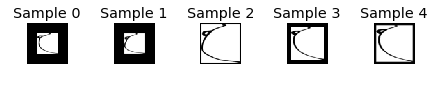

In [5]:
fig = plt.figure()

for i in range(len(imagenet_data)):
    sample = imagenet_data[i + 10]
    #print(sample)
    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    plt.imshow(np.asarray(sample[0]), cmap=plt.cm.gray_r)
    ax.set_title('Sample {}'.format(i))
    ax.axis('off')

    if i == 4:
        plt.show()
        break

#### Process type of vessels for classification

In [6]:
df = utils.create_df_from_files(path='data/clases/')

1
2
3
4
5
6
7
8
9
10
11


#### Build and train classifier

In [7]:
imagenet_data = datasets.ImageFolder('data/png_clasificados/',
                                     transform=tfs.Compose([tfs.RandomHorizontalFlip(p=0.7),
                                                           tfs.RandomAffine(0, scale=(0.7, 1.), fillcolor=0),
                                                           tfs.Resize((64, 64)),
                                                           tfs.Grayscale(1),
                                                           tfs.Lambda(lambda x: PIL.ImageOps.invert(x)),
                                                           tfs.ToTensor(),
                                                           tfs.Normalize((0.5,), (0.5,))]))



In [8]:
splits_len = round(len(imagenet_data.samples)*0.2), round(len(imagenet_data.samples)*0.1), round(len(imagenet_data.samples)*0.7)

In [9]:
splits_len = splits_len if np.sum(splits_len) == len(imagenet_data.samples) else splits_len[0], splits_len[1], splits_len[2]+1

#### Random split

In [10]:
splits_len

(256, 128, 898)

In [11]:
np.sum(splits_len)

1282

In [12]:
splits = utils.random_split(imagenet_data, (1282, 0))

#train_loader = data.DataLoader(splits[2], batch_size=32, shuffle=False)
#val_loader = data.DataLoader(splits[1], batch_size=32, shuffle=False)
test_loader = data.DataLoader(splits[0], batch_size=32, shuffle=False)


In [13]:
import torch.optim as optim
from torch import nn
from models.classifier import _C
import visdom
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import TopKCategoricalAccuracy, Loss
from ignite.handlers import ModelCheckpoint
import torch.nn.functional as F

In [14]:
C =_C(input_h_w=64)
C = C.to(available_device)

In [15]:
checkpoint = torch.load("models/checkpoint/myprefix_model_500.pth")
C.load_state_dict(checkpoint)

In [16]:
from sklearn import metrics

def iterations_test(C, test_loader):
    y_real = list()
    y_pred = list()

    for ii, data_ in enumerate(test_loader):
        input_, label = data_
        val_input = Variable(input_).to(available_device)
        val_label = Variable(label.type(torch.LongTensor)).to(available_device)
        score = C(val_input)
        _, y_pred_batch = torch.max(score, 1)
        y_pred_batch = y_pred_batch.cpu().squeeze().numpy()
        y_real_batch = val_label.cpu().data.squeeze().numpy()
        y_real.append(y_real_batch.tolist())
        y_pred.append(y_pred_batch.tolist())

    y_real = [item for batch in y_real for item in batch]
    y_pred = [item for batch in y_pred for item in batch]
    
    return y_real, y_pred

def iterations_test_partial(C, test_loader):
    y_real = list()
    y_pred = list()
    for ii, data_ in enumerate(test_loader):
        input_, label = data_
        val_input = Variable(input_).to(available_device)
        val_label = Variable(label.type(torch.LongTensor)).to(available_device)
        score = C.forward_partial(val_input)
        y_pred_batch = score.detach().cpu().squeeze().numpy()
        y_real_batch = val_label.cpu().data.squeeze().numpy()
        y_real.append(y_real_batch.tolist())
        y_pred.append(y_pred_batch.tolist())

    y_real = [item for batch in y_real for item in batch]
    y_pred = [item for batch in y_pred for item in batch]
    
    return y_real, y_pred

In [17]:
y_real, y_pred = iterations_test(C, test_loader)
print(metrics.classification_report(np.array(y_pred), np.array(y_real)))

/home/pablo/miniconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


              precision    recall  f1-score   support

           0       0.96      0.96      0.96        50
           1       0.98      0.98      0.98       372
           2       0.95      0.96      0.96       142
           3       0.78      0.80      0.79        65
           4       0.93      0.95      0.94        74
           5       0.70      1.00      0.82         7
           6       0.96      1.00      0.98        55
           7       0.95      0.93      0.94        59
           8       0.99      0.93      0.96        73
           9       0.96      0.94      0.95       362
          10       0.91      0.87      0.89        23

   micro avg       0.95      0.95      0.95      1282
   macro avg       0.91      0.94      0.92      1282
weighted avg       0.95      0.95      0.95      1282



In [18]:
y_real, y_pred = iterations_test_partial(C, test_loader)

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(y_pred)  

print(np.sum(pca.explained_variance_ratio_))

0.2009919925297461


In [20]:
colors = plt.cm.afmhot(np.linspace(0, 1, len(x_pca)) * (np.array(y_real)+1)/11)

In [21]:
import pandas as pd

In [39]:
from sklearn.cluster import KMeans
lbls = KMeans(n_clusters=7, random_state=0).fit_predict(y_pred)

In [40]:
#from sklearn.cluster import MeanShift
#lbls = MeanShift(512).fit_predict(y_pred)

In [41]:
np.unique(lbls)

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

In [42]:
interest_feat = range(10)
data_x_pca = pd.DataFrame(x_pca)
#data["labels"]= np.sum(colors, 1)
data_x_pca["labels"]= lbls
#pd.plotting.scatter_matrix(data_x_pca.loc[:,interest_feat[:-1]], figsize=(12,8), diagonal='kde', c=lbls)
#plt.show()

In [43]:
colors = np.ones_like(lbls, dtype=np.str)

In [44]:
colors[lbls == 0] = "r"
colors[lbls == 1] = "g"
colors[lbls == 2] = "b"
colors[lbls == 3] = "y"

In [45]:
files = np.array(imagenet_data.imgs)[test_loader.dataset.indices][:, 0]

In [46]:
merged = pd.DataFrame(np.concatenate(( np.expand_dims(files, 1), np.expand_dims(lbls, 1)), axis=1))

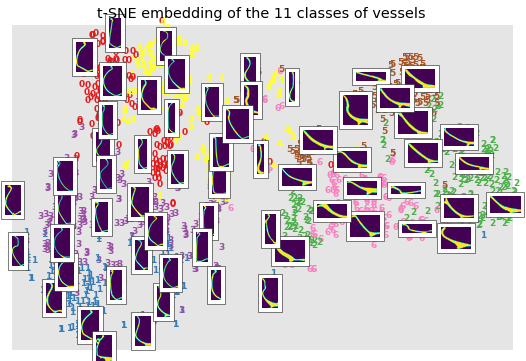

In [ ]:
from time import time
from sklearn import manifold

plt.rcParams['figure.figsize'] = [6.0 * 1.5 , 4.0 * 1.5]

#id_ =  merged['id']
#class_ = merged['class']
#merged_tsne_2d = merged.drop(['id', 'class'], axis=1)

#print("Computing t-SNE embedding of the 11 classes of  vessel")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
#t0 = time()
#print(merged.values)
X_tsne = tsne.fit_transform(y_pred)
utils.plot_embedding(X_tsne, merged,
               "t-SNE embedding of the 11 classes of vessels", np.unique(lbls).shape[0])

plt.grid()
plt.show()

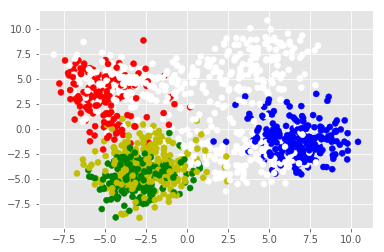

In [ ]:
plt.rcParams['figure.figsize'] = [6.0, 4.0 ]
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=colors)

In [ ]:
clusters = {i:[] for i in np.unique(lbls)} 
for img, j in zip(files, lbls):
    clusters[j].append(img)

In [ ]:
import skimage

154
170
222
240
181
151
164


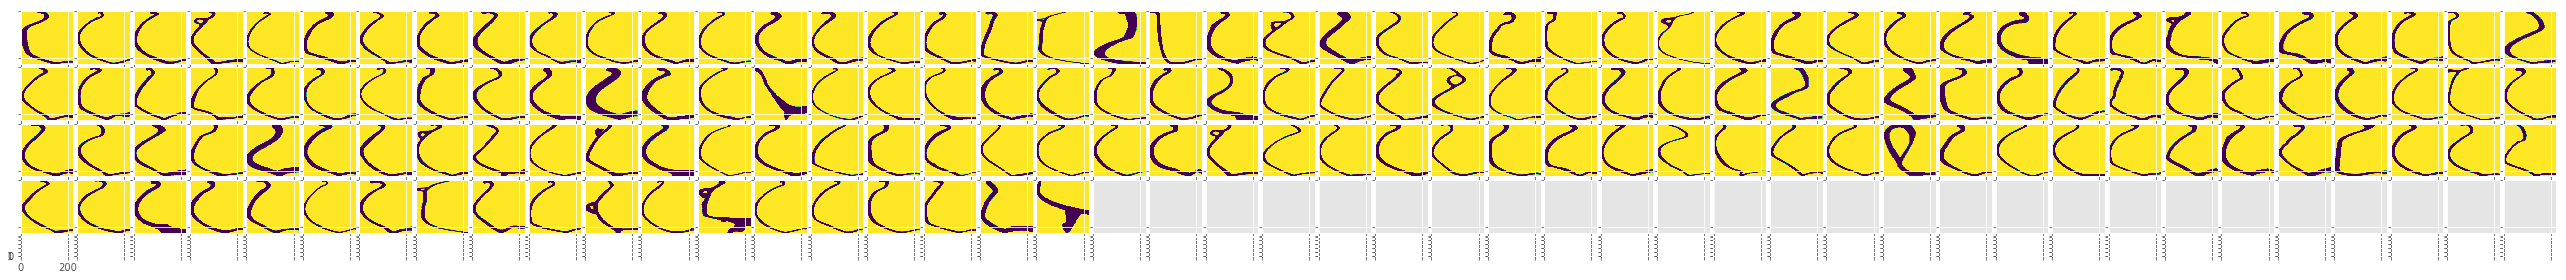

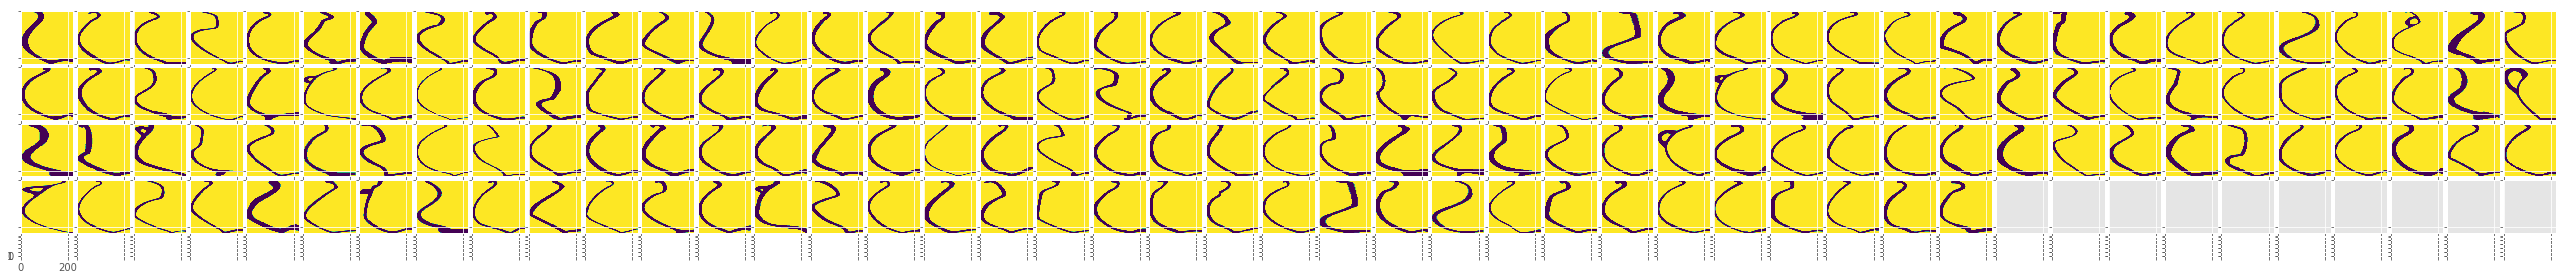

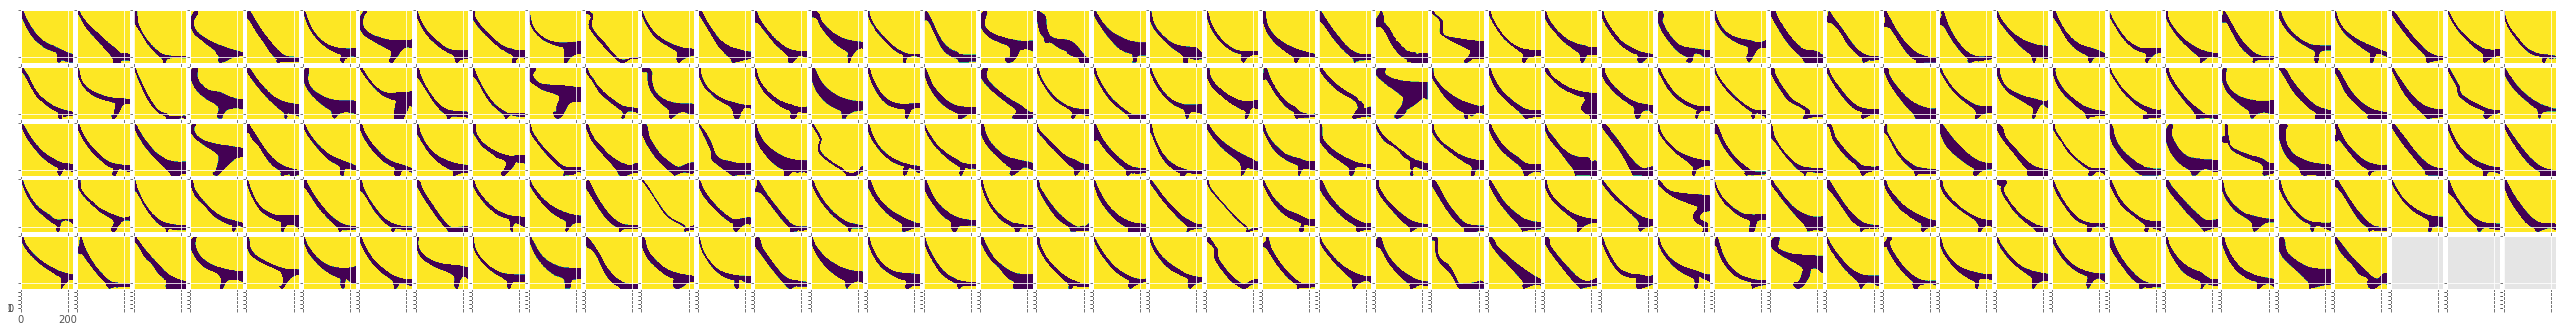

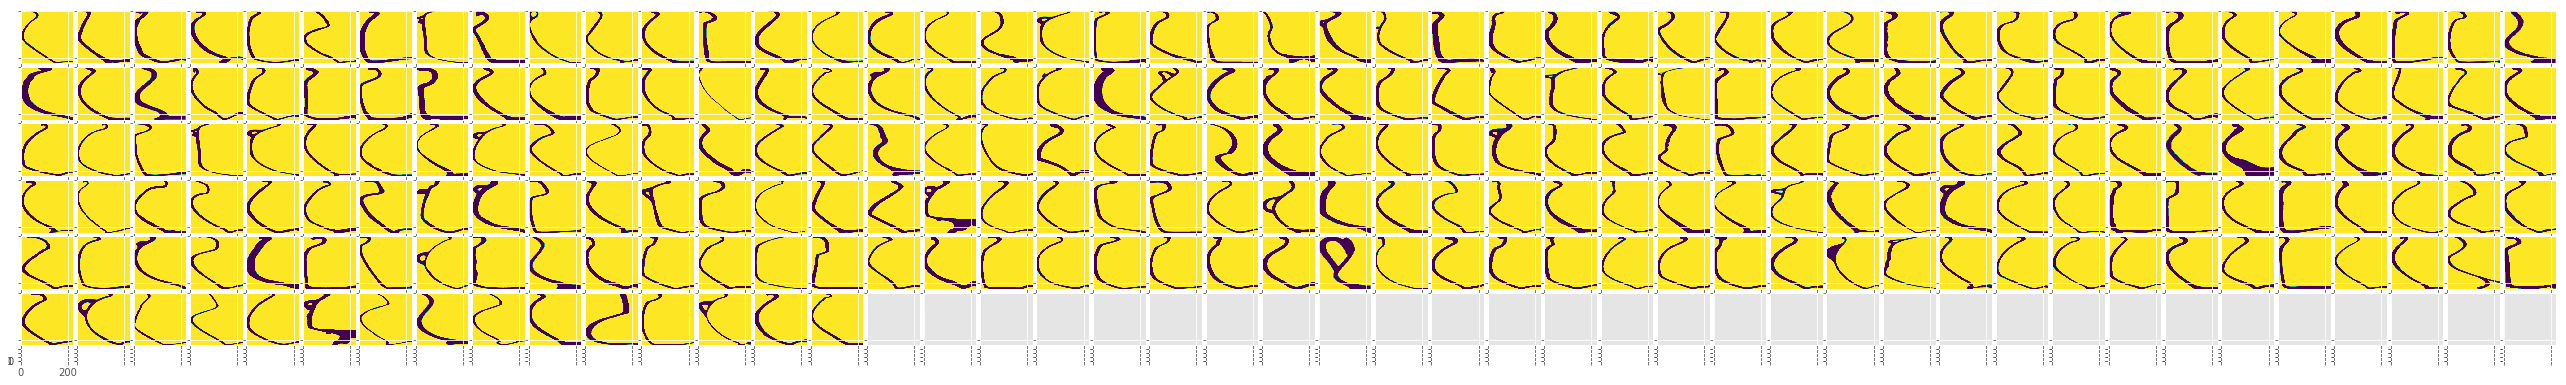

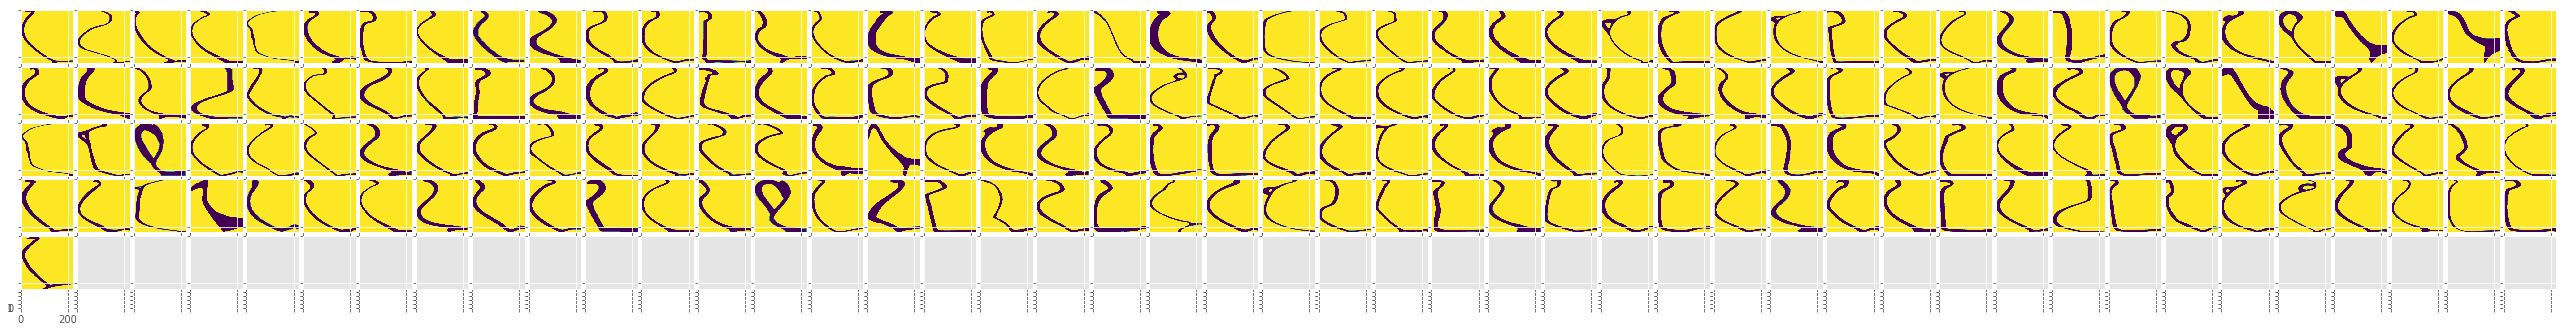

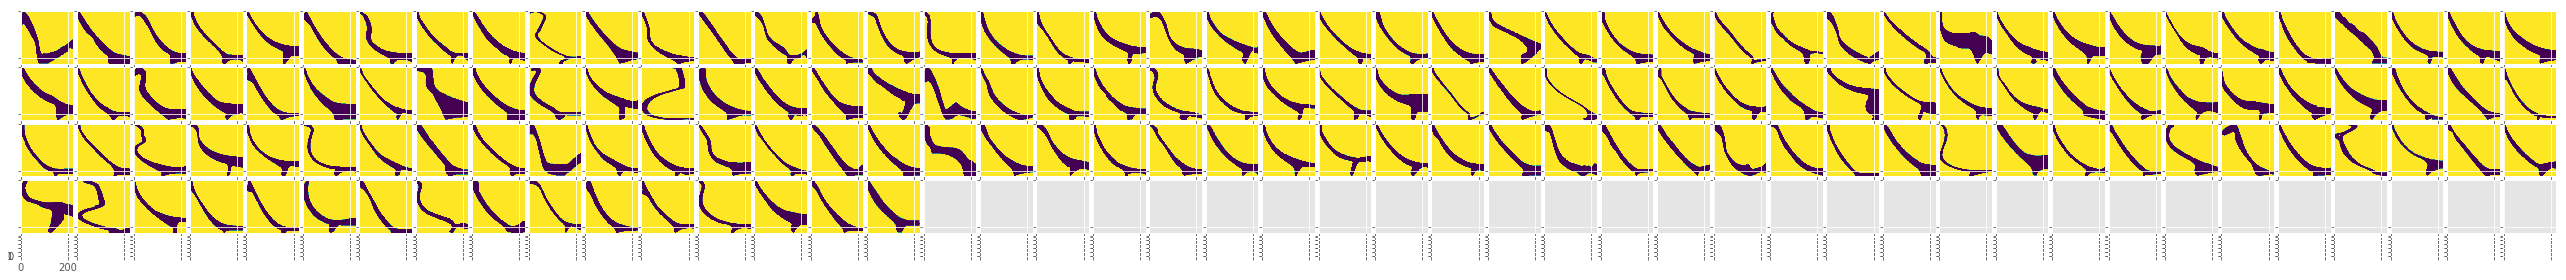

In [ ]:
plt.rcParams['figure.figsize'] = [6.0 * 30, 4.0 * 30]
from mpl_toolkits.axes_grid1 import AxesGrid
for c in clusters.values():
    fig = plt.figure()
    fig.subplots_adjust(left=0.05, right=0.95)
    grid = AxesGrid(fig, 141, 
                    nrows_ncols=(10, 45),
                    axes_pad=0.05,
                    label_mode="1")
    print(len(c))
    for i, img in enumerate(c):
        grid[i].imshow(skimage.transform.resize(skimage.io.imread(img, 1), (224,224)))